# ANL Revision Bot Jul 19 Analysis Report


### 1. Introduction<br>

During the Jul 19 semester, I took on a two-part personal project of creating a revision tool for BA students in preparation for the final exams. The tool was a telegram chatbot that allowed students to practice PCQ questions from the 3 ANL modules that BA students were enrolled in namely, ANL303 Fundamentals of Data Mining, ANL305 Association & Clustering and ANL321 Statistical Methods. 

Telegram was chosen as the medium for delivering the quiz for 2 reasons. The first was to encourage frequent  <a href='http://www.flashcardlearner.com/articles/what-is-spaced-repetition/'>spaced repetition</a> - a technique shown to be effecive in improving recall. Telegram is an instant messaging app available on mobile devices, which allows the quiz to be easily accessible without the need for logins, loading of websites or documents. The second reason was that there was not much front-end development (e.g. UI elements) needed as the quiz will be delivered through a chatbot. This expedited the completion of the bot. Here is a screenshot of the bot:

![arbot.png](arbot.png)<br><br>

The bot was programmed to collect data from users. Part 2 of the project involved performing analysis on the data collected to derive actionable insights. Thus, this report aims to present the findings derived and share the methods that were used to obtain them.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import dataset
df=pd.read_csv('anlbotdata.csv')
pd.options.mode.chained_assignment = None

The dataset contains 141 records. Each record represents a quiz attempt by a student. It also contains 5 attributes. The description of the attributes are shown in one of the tables below.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
user_id     141 non-null int64
module      141 non-null object
num_q       141 non-null int64
r_score     141 non-null int64
datetime    141 non-null object
dtypes: int64(3), object(2)
memory usage: 5.6+ KB


Table of attributes in dataset

| Attribute name | Description | Data type |
|---|---|---|
| user_id | Student's unique telegram id | Integer |
| module | Module code of selected quiz | String |
| num_q | Number of questions selected for quiz | Integer |
| r_score| Number of questions answered correctly | Integer |
| datetime | Date and time of attempt | Datetime |

In [4]:
df.head()

,user_id,module,num_q,r_score,datetime
0,436076599,ANL303,10,0,1/11/2019 19:01
1,27434070,ANL305,10,1,1/11/2019 19:50
2,245439523,ANL305,10,10,1/11/2019 19:50
3,244400044,ANL303,10,9,1/11/2019 19:50
4,571453235,ANL305,10,9,1/11/2019 19:50


In [5]:
# Number of unique users
df['user_id'].nunique()

36

There were **36** unique users of the bot.

### 2. Data preparation

#### a (i). Transform raw score to percentage score

The r_score attribute contains the number of questions answered correctly by the user. However, the total number of questions in the quiz can either be 10, 15 or 20 depending on the user's selection. Thus, the raw score needs to be expresed as a percentage of the total number of questions (num_q) to be suitable for analysis. The new attribute will be named 'score'.

In [6]:
# Create new column labeled 'score'
df['score']=df['r_score']/df['num_q']
df.head()

,user_id,module,num_q,r_score,datetime,score
0,436076599,ANL303,10,0,1/11/2019 19:01,0.0
1,27434070,ANL305,10,1,1/11/2019 19:50,0.1
2,245439523,ANL305,10,10,1/11/2019 19:50,1.0
3,244400044,ANL303,10,9,1/11/2019 19:50,0.9
4,571453235,ANL305,10,9,1/11/2019 19:50,0.9


In [7]:
# Check records with zero score
sum(df['score']== 0)

6

There are 6 records with a score of 0. These included test runs of the bot and thus, should be treated as anomalies. They are removed from the dataset.

In [8]:
# Removing records with score = 0
df = df[df['score'] != 0]
sum(df['score']==0)

0

In [9]:
# Cleaned dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 1 to 140
Data columns (total 6 columns):
user_id     135 non-null int64
module      135 non-null object
num_q       135 non-null int64
r_score     135 non-null int64
datetime    135 non-null object
score       135 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.4+ KB


In [10]:
df['user_id'].nunique()

36

The cleaned dataset now contains 135 records and 6 attributes.

In [11]:
# Sort records by module
df=df.sort_values('module')
df.head()

,user_id,module,num_q,r_score,datetime,score
140,36396689,ANL303,10,5,19/11/2019 14:08,0.500000
94,459561854,ANL303,10,6,11/11/2019 18:20,0.600000
95,50347840,ANL303,10,7,11/11/2019 23:45,0.700000
96,50347840,ANL303,15,14,11/11/2019 23:50,0.933333
57,245445727,ANL303,20,19,3/11/2019 18:30,0.950000


#### a (ii). Preliminary analysis <br>
##### Descriptive statistics of attempts and performance per module

The output below shows the number of quiz attempts per module. ANL303 has the greatest number while ANL321 has the lowest, although there is only a difference of 1 between ANL321 and ANL305.

In [12]:
# Number of attempts (non-unique) per module
df['module'].value_counts()

ANL303    50
ANL305    43
ANL321    42
Name: module, dtype: int64

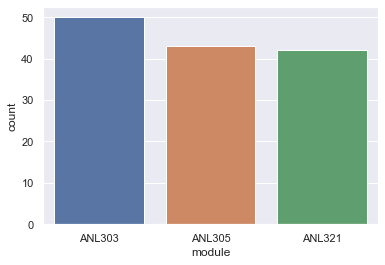

In [13]:
# Bar plot of attempts per module
sns.set(style='darkgrid')
sns.countplot(x='module',data=df)

The table below summarises the quiz performance for each module. Attempts for ANL303 and ANL305 had mean scores of 0.75, while attempts for ANL321 had a mean score of 0.638. The standard deviations between the modules did not vary much.

The weaker performance in ANL321 may reflect the inherent difficulty of the module's content, which has a stronger emphasis on theoretical and mathematical concepts. Additionally, ANL305 is practically an extension of ANL303, with a reasonable amount of overlap in content. Thus, it may be expected that performance would be similar between the two.

From the box and distribution plots, it is observed that ANL305 contains a few outliers with scores significanlty below the mean. The presence of these extremely low scores suggest that further cleaning of the data may be required.

In [14]:
# Summary of quiz performance per module
df.groupby('module')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
module,,,,,,,,
ANL303,50.0,0.751667,0.216346,0.200000,0.6125,0.8,0.900,1.0
ANL305,43.0,0.753488,0.243447,0.066667,0.7000,0.8,0.925,1.0
ANL321,42.0,0.638492,0.244020,0.100000,0.5000,0.7,0.800,1.0


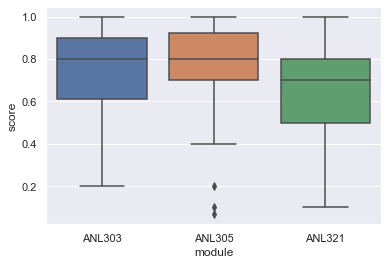

In [15]:
# Box plots of quiz performance per module
sns.boxplot(x='module',y='score',data=df)

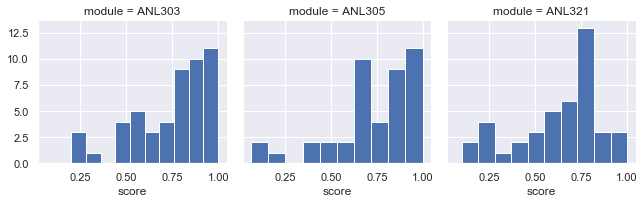

In [16]:
# Distribution plots of quiz performance per module
g1 = sns.FacetGrid(df,col='module')
g1 = g1.map(plt.hist, 'score')

#### a (iii). Data cleaning<br>

##### Removing outliers
There may be more outliers present in the data than the ones seen in the box plots. Here, the scores have been standardised based on the means and standard deviations of the respective modules. The threshold was set to 99%, corresponding to the critical values of +- 2.576. 

It was discovered that 2 attempts had z-scores of lower than -2.576. It is possible that users of these attempts chose to end the quiz prematurely, resulting in a low score. This information should be captured in future iterations of the bot in order to differentiate between genuine and incomplete attempts. For the purposes of this report, these attempts were assumed to be incomplete quizzes and were therefore removed.

In [17]:
from scipy import stats

In [18]:
# Convert to z-scores based on means & sd of scores for each module
df['z_score'] = df.groupby('module').score.transform(lambda x : stats.zscore(x))

In [19]:
# Identify outliers at 99% confidence interval
outliers = df[df['z_score'].abs() > 2.576]
outliers

,user_id,module,num_q,r_score,datetime,score,z_score
1,27434070,ANL305,10,1,1/11/2019 19:50,0.100000,-2.716078
49,254707876,ANL305,15,1,2/11/2019 11:06,0.066667,-2.854621


In [20]:
# Remove outliers from df
df = df[~df['z_score'].isin(outliers['z_score'])]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 140 to 71
Data columns (total 7 columns):
user_id     133 non-null int64
module      133 non-null object
num_q       133 non-null int64
r_score     133 non-null int64
datetime    133 non-null object
score       133 non-null float64
z_score     133 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 8.3+ KB


#### b. Adding new attributes: Exam Date & Days left<br>
The collection of user data was deliberately limited so as to not hinder the user experience and the bot's primary purpose. This resulted in the small number of attributes of the dataset. However, using some attributes that were implicitly recorded by the bot, we can derive some new feature that may be useful in this analysis.

I thought that the number of days left until the exam of the module may be an interesting feature to be imputed here. I hypothesize a negative relationship may be present between the quiz score and number of days left; students would have revised more nearer to the exam date and thus would score better on the quiz.

This sub-section explains how this new attribute was derived.

In [22]:
# Add new attribute: Exam date
exam_date={'ANL303':'2019-11-12','ANL305':'2019-11-19','ANL321':'2019--11-14'}
df['exam_date']=df['module'].map(exam_date)
df.head()

,user_id,module,num_q,r_score,datetime,score,z_score,exam_date
140,36396689,ANL303,10,5,19/11/2019 14:08,0.500000,-1.175071,2019-11-12
94,459561854,ANL303,10,6,11/11/2019 18:20,0.600000,-0.708155,2019-11-12
95,50347840,ANL303,10,7,11/11/2019 23:45,0.700000,-0.241240,2019-11-12
96,50347840,ANL303,15,14,11/11/2019 23:50,0.933333,0.848230,2019-11-12
57,245445727,ANL303,20,19,3/11/2019 18:30,0.950000,0.926049,2019-11-12


In [23]:
# Check type of datetime
df.datetime.dtype

dtype('O')

In [24]:
# Convert dates to timestamp object
df['datetime']=pd.to_datetime(df['datetime'],dayfirst=True, yearfirst=False)
df.head()

,user_id,module,num_q,r_score,datetime,score,z_score,exam_date
140,36396689,ANL303,10,5,2019-11-19 14:08:00,0.500000,-1.175071,2019-11-12
94,459561854,ANL303,10,6,2019-11-11 18:20:00,0.600000,-0.708155,2019-11-12
95,50347840,ANL303,10,7,2019-11-11 23:45:00,0.700000,-0.241240,2019-11-12
96,50347840,ANL303,15,14,2019-11-11 23:50:00,0.933333,0.848230,2019-11-12
57,245445727,ANL303,20,19,2019-11-03 18:30:00,0.950000,0.926049,2019-11-12


In [25]:
# Check new type
df.datetime.dtype

dtype('<M8[ns]')

In [26]:
# Split datetime column to date & time
df['date']=df['datetime'].apply(lambda t:t.date())
df['time']=df['datetime'].apply(lambda t:t.time())

In [27]:
df.head()

,user_id,module,num_q,r_score,datetime,score,z_score,exam_date,date,time
140,36396689,ANL303,10,5,2019-11-19 14:08:00,0.500000,-1.175071,2019-11-12,2019-11-19,14:08:00
94,459561854,ANL303,10,6,2019-11-11 18:20:00,0.600000,-0.708155,2019-11-12,2019-11-11,18:20:00
95,50347840,ANL303,10,7,2019-11-11 23:45:00,0.700000,-0.241240,2019-11-12,2019-11-11,23:45:00
96,50347840,ANL303,15,14,2019-11-11 23:50:00,0.933333,0.848230,2019-11-12,2019-11-11,23:50:00
57,245445727,ANL303,20,19,2019-11-03 18:30:00,0.950000,0.926049,2019-11-12,2019-11-03,18:30:00


In [28]:
# Convert exam_date column to date objects
df['exam_date']=pd.to_datetime(df['exam_date'])
df['exam_date']=df['exam_date'].apply(lambda t:t.date())

In [29]:
df.exam_date.dtype

dtype('O')

In [30]:
# Derive new variable: days left until exam
df['days_left']=df['exam_date']-df['date']
df['days_left']=df['days_left'].apply(lambda t:t.days)
df.head()

,user_id,module,num_q,r_score,datetime,score,z_score,exam_date,date,time,days_left
140,36396689,ANL303,10,5,2019-11-19 14:08:00,0.500000,-1.175071,2019-11-12,2019-11-19,14:08:00,-7
94,459561854,ANL303,10,6,2019-11-11 18:20:00,0.600000,-0.708155,2019-11-12,2019-11-11,18:20:00,1
95,50347840,ANL303,10,7,2019-11-11 23:45:00,0.700000,-0.241240,2019-11-12,2019-11-11,23:45:00,1
96,50347840,ANL303,15,14,2019-11-11 23:50:00,0.933333,0.848230,2019-11-12,2019-11-11,23:50:00,1
57,245445727,ANL303,20,19,2019-11-03 18:30:00,0.950000,0.926049,2019-11-12,2019-11-03,18:30:00,9


The outputs below show summary statistics and a distribution plot of the number of attempts as a function of the number of days left before the module's paper.

The telegram bot was released to the BA cohort on 1 Nov 2019. Among the 3 modules, ANL303 was the first paper on 12 Nov and ANL305 was the last paper on 19 Nov. This limits the range of days_ left to be between 0 and 18. 

The mean number of days left is 6.96, while the mode is 1.

In [31]:
# Top 5 days of usage
df['days_left'].value_counts().head()

1     27
13    21
11    18
0     12
18    11
Name: days_left, dtype: int64

In [32]:
df['days_left'].describe()

count    133.000000
mean       6.969925
std        6.030151
min       -7.000000
25%        1.000000
50%        6.000000
75%       12.000000
max       18.000000
Name: days_left, dtype: float64

#### b (i). Removing anomalies in days_left

There seemed to be an outlier with the minimum number of days left being -7. This indicates that the quiz attempt was made a week after the paper ended. This record was treated as an anomaly and subsequently removed from the dataset.

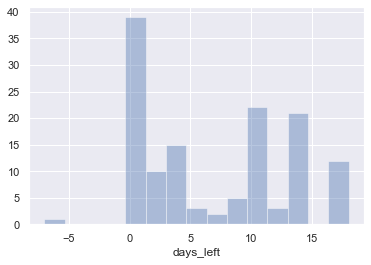

In [33]:
# Distribution of days_left
sns.distplot(df['days_left'],kde=False, bins=15)

In [34]:
# Records of attempts made after paper
df[df['days_left'] < 0]

,user_id,module,num_q,r_score,datetime,score,z_score,exam_date,date,time,days_left
140,36396689,ANL303,10,5,2019-11-19 14:08:00,0.5,-1.175071,2019-11-12,2019-11-19,14:08:00,-7


In [35]:
df = df[~df['days_left'] < 0]

The final version of the dataset now contains 132 records and 11 attributes.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 94 to 71
Data columns (total 11 columns):
user_id      132 non-null int64
module       132 non-null object
num_q        132 non-null int64
r_score      132 non-null int64
datetime     132 non-null datetime64[ns]
score        132 non-null float64
z_score      132 non-null float64
exam_date    132 non-null object
date         132 non-null object
time         132 non-null object
days_left    132 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 12.4+ KB


### 3. Exploratory analysis

The following section presents the findings of exploratory analysis on the dataset. Previously stated hypotheses were also tested here albeit not in a statistically rigorous fashion.

#### a. Usage data

The histogram below shows the number of users per day. It is observed that the number of attempts peaked at about 1 day before module's paper.

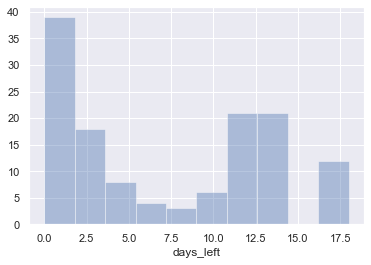

In [37]:
# Number of attempts (non-unique) per day
sns.distplot(df['days_left'],kde=False,bins=10)

The table and heatmap below split the usage data one level further based on the module. The brighter colours on the right-most spots of each module indicate that the usage also peaked when the bot was first released.

In [38]:
# Number of attempts per day according to module

df2=df.groupby(['module','days_left']).count()['user_id'].unstack()
df2

days_left,0,1,2,3,4,5,6,7,8,9,10,11,12,13,17,18
module,,,,,,,,,,,,,,,,
ANL303,5.0,15.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,2.0,2.0,18.0,NaN,NaN,NaN,NaN
ANL305,3.0,9.0,5.0,5.0,4.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,11.0
ANL321,4.0,3.0,2.0,2.0,NaN,1.0,2.0,NaN,3.0,NaN,2.0,NaN,2.0,21.0,NaN,NaN


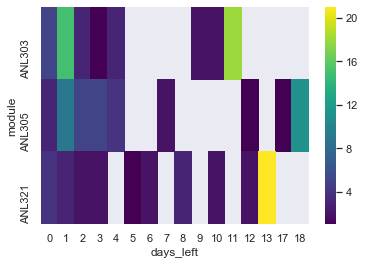

In [39]:
sns.heatmap(df2,cmap='viridis')

#### b. Performance data

####  b (i). Preliminary analysis

Referring to the table and heatmap below, we observe a general improvement in scores for ANL303 as the days left approaches 0. This pattern is less prominent in ANL305 and even less so in ANL321.

In [40]:
# Mean scores per day according to module

df3=df.groupby(['module','days_left']).mean()['score'].unstack()
df3

days_left,0,1,2,3,4,5,6,7,8,9,10,11,12,13,17,18
module,,,,,,,,,,,,,,,,
ANL303,0.940000,0.828889,0.816667,1.00,0.783333,NaN,NaN,NaN,NaN,0.775,0.65,0.627778,NaN,NaN,NaN,NaN
ANL305,0.661111,0.905556,0.930000,0.92,0.750000,NaN,NaN,0.45,NaN,NaN,NaN,NaN,0.2,NaN,0.9,0.713636
ANL321,0.700000,0.816667,0.400000,0.75,NaN,0.8,0.65,NaN,0.6,NaN,0.75,NaN,0.6,0.603175,NaN,NaN


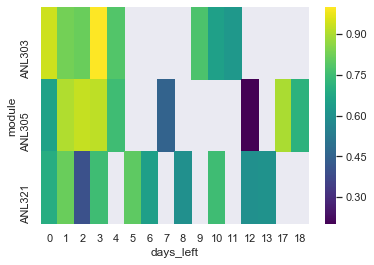

In [41]:
# Heatmap of mean scores per day according to module
sns.heatmap(df3,cmap='viridis')

#### b (ii). Relationship between days left and score

I had previously hypothesized that quiz attempts made closer to the exam date will have higher scores than those made earlier. The correlation analysis revealed an correlation coefficient of -0.3514 between the two variables. This provides support for the existence of a negative relationship between days left and quiz performance. <br><br>

*It should be noted that proper hypothesis testing demands the use of more rigorous procedures. The analysis included in this report are exploratory in nature and does not aim to establish any conclusions from the data.

In [42]:
# Computing correlatio between days left & score
df['days_left'].corr(df['score'])

-0.35141896390614824

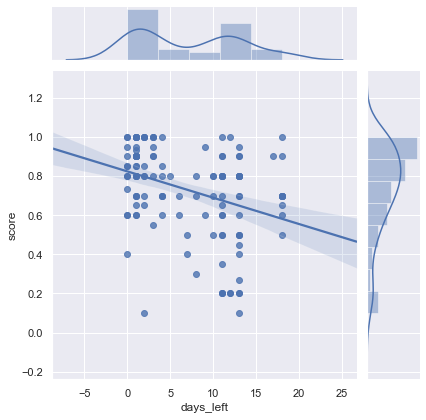

In [43]:
# Scatter plot of days left and score
sns.jointplot(x='days_left',y='score',data=df,kind='reg')

#### c. Performance data according to user type<br>

When looking at the user data, I noticed that there were a handful of user ids (out of the 34 unique users) that were frequent users of the bot. 

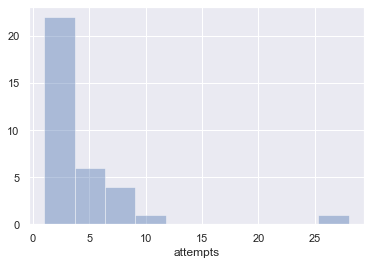

In [44]:
# Distribution of usage (no. of times)

all_users = pd.DataFrame(df['user_id'].value_counts())
all_users.rename(columns={'user_id':'attempts'}, inplace=True)
sns.distplot(all_users['attempts'],kde=False,bins=10)

In [45]:
all_users.head()

,attempts
401749345,28
142406316,11
656956327,9
245445727,9
657189766,8


Of the 34 unique users, 9 were regular and 25 were non-regular.

The 9 regular users had a combined total of 88 attempts between them, accounting for 66% of the total number of attempts. 

In [46]:
# Extract user_id of regular users into list (used bot at least 5 times)

reg_users=pd.DataFrame(all_users[all_users['attempts']>=5].reset_index())
reg_users_id = reg_users['index'].to_list()

In [47]:
# Number of non-regular users
len(all_users) - len(reg_users)

25

#### c (i). Performance of regular users<br>

According to the output below, the mean score for regular users (across all modules) was 0.7708 with a standard deviation of 0.2173. 

The distribution plot reveals a pronounced negative skew, indicating that a great proportion of attempts by these users resulted in high scores.

In [48]:
# Subset of df for regular users
df_reg_users = df[df['user_id'].isin(reg_users_id)]
df_reg_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 95 to 71
Data columns (total 11 columns):
user_id      88 non-null int64
module       88 non-null object
num_q        88 non-null int64
r_score      88 non-null int64
datetime     88 non-null datetime64[ns]
score        88 non-null float64
z_score      88 non-null float64
exam_date    88 non-null object
date         88 non-null object
time         88 non-null object
days_left    88 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 8.2+ KB


In [49]:
# Summary statistics of regular users
df_reg_users['score'].describe()

count    88.000000
mean      0.770833
std       0.217266
min       0.100000
25%       0.700000
50%       0.800000
75%       0.950000
max       1.000000
Name: score, dtype: float64

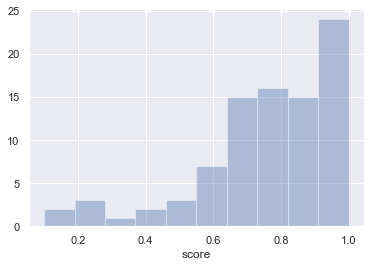

In [50]:
# Distribution of scores of regular users
sns.distplot(df_reg_users['score'],kde=False, bins=10)

The summary statistics table, distribtuions and box plots show that on average, regular users tend to perform better for ANL303 (0.7984) and ANL305 (0.8253) compared to ANL321 (0.684)

The spread in the scores for ANL321 (0.22489) was also greater than the other 2 modules (ANL303 sd = 0.2097, ANL305 sd = 0.1717).

In [51]:
# Summary statistics of regular users' scores according to module

df_reg_users.groupby('module')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
module,,,,,,,,
ANL303,32.0,0.794792,0.209601,0.2,0.65,0.875,0.9625,1.0
ANL305,29.0,0.825287,0.171745,0.4,0.70,0.900,1.0000,1.0
ANL321,27.0,0.683951,0.248907,0.1,0.65,0.800,0.8000,1.0


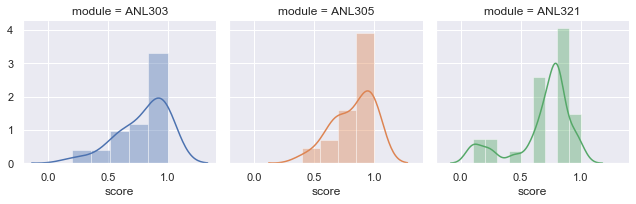

In [52]:
# Distribution of scores of regular users according to module

g2 = sns.FacetGrid(df_reg_users,col='module',hue='module')
g2 = g2.map(sns.distplot, 'score')

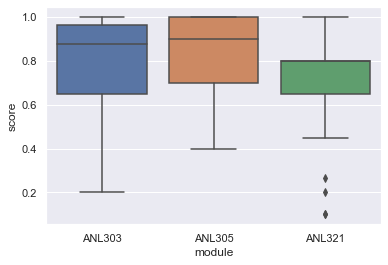

In [53]:
# Box plots of scores of regular users according to module

sns.boxplot(x='module', y='score',data=df_reg_users)

#### c (ii). Relationship between regular users' scores and days left 

The scatter plot displays a regression line with a downward slope with an $R^{2}$ value of -0.4472. This provides support for the hypothesized relationship.

In [54]:
# Correlation between regular users' scores and days left 
df_reg_users[['score','days_left']].corr()

,score,days_left
score,1.000000,-0.447175
days_left,-0.447175,1.000000


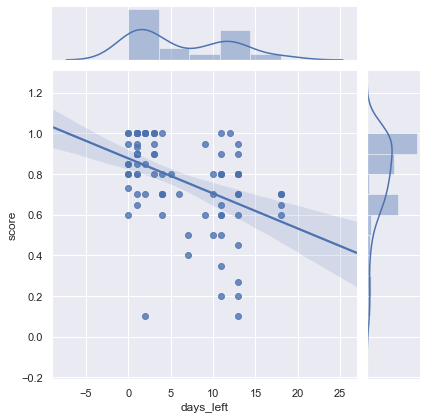

In [55]:
# Relationship between days left and scores of regular users
sns.jointplot(x ='days_left',y='score',data=df_reg_users, kind='reg')

The relationship between days left and scores also differed between modules. Looking at the regression plots below, there is a much steeper slope for ANL303 and ANL305 compared to ANL321, in which the regression line is much flatter. This indicates that having more time to revise ANL321 did not lead to a great improvement of scores. 

One explanation could be the difference in exam schedules. Most BA students were also taking the FIN203 paper on the same day as ANL321. ANL303 and ANL305 were the only BA papers on their respective dates. Thus, students would have had to allocate their time to revise for another module which could explain the lack of improvement in scores in ANL321.

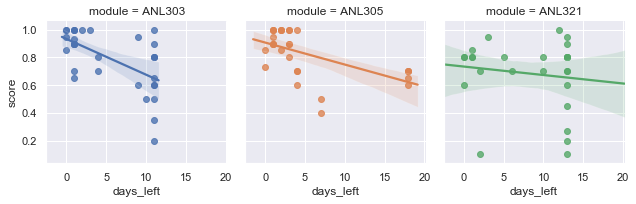

In [56]:
# Relationship between days left and score of regular users according to module.

g3 = sns.FacetGrid(df_reg_users,col='module',hue='module')
g3 = g3.map(sns.regplot, 'days_left','score')

#### c (iii). Non-regular users <br>

Users who had attempted fewer than 5 quizzes were labelled as non-regular. There were 25 unique non-regular users with  a combined total of 44 attempts made between them.

In [57]:
# Extract attempts made by non-regular users
df_non_reg_users=df[~df['user_id'].isin(reg_users_id)]
df_non_reg_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 94 to 45
Data columns (total 11 columns):
user_id      44 non-null int64
module       44 non-null object
num_q        44 non-null int64
r_score      44 non-null int64
datetime     44 non-null datetime64[ns]
score        44 non-null float64
z_score      44 non-null float64
exam_date    44 non-null object
date         44 non-null object
time         44 non-null object
days_left    44 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 4.1+ KB


In [58]:
# Number of non-regular users
df_non_reg_users['user_id'].nunique()

25

#### c (iv). Performance of non-regular users

According to the output below, the mean score for non-regular users across all modules was 0.6432 with a standard deviation of 0.2235. This is a lower average score and a higher spread compared to the regular users.

A negative skew can also be observed in the distribution plot.

In [59]:
# Summary statistics of non-regular users
df_non_reg_users['score'].describe()

count    44.000000
mean      0.643182
std       0.223500
min       0.200000
25%       0.500000
50%       0.700000
75%       0.800000
max       1.000000
Name: score, dtype: float64

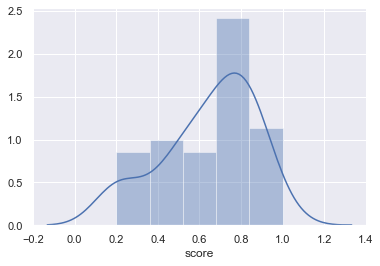

In [60]:
sns.distplot(df_non_reg_users['score'])

Non-regular users performed worse than regular users with a mean difference of 0.1 across all modules. 

Interestingly, we observe the same pattern as with the regular users in which students performed better for ANL303 and ANL305 compared to ANL321. The spread in the scores however did not vary much between modules.

In [61]:
# Summary statistics of non-regular users' scores according to module

df_non_reg_users.groupby('module')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
module,,,,,,,,
ANL303,17.0,0.685294,0.214159,0.2,0.60,0.80,0.800,0.9
ANL305,12.0,0.691667,0.227470,0.2,0.65,0.70,0.825,1.0
ANL321,15.0,0.556667,0.219469,0.2,0.45,0.55,0.750,0.9


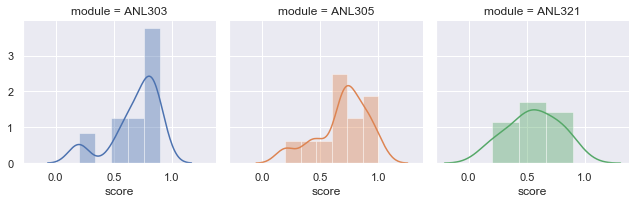

In [62]:
g4 = sns.FacetGrid(df_non_reg_users,col='module',hue='module')
g4 = g4.map(sns.distplot, 'score')

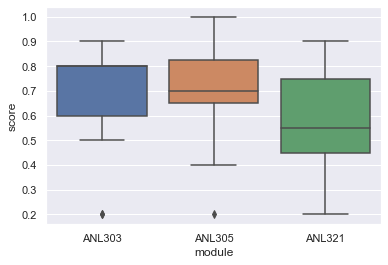

In [63]:
sns.boxplot(x='module', y='score',data=df_non_reg_users)

#### c (v). Relationship between non-regular users' scores and days left

The scatter plot fails to show any significant relationship between the scores and number of days left (corr = -0.07) for non-regular users, which was previously found for regular users.

In [64]:
# Correlation between non-regular users' scores and days left
df_non_reg_users[['score','days_left']].corr()

,score,days_left
score,1.000000,-0.071559
days_left,-0.071559,1.000000


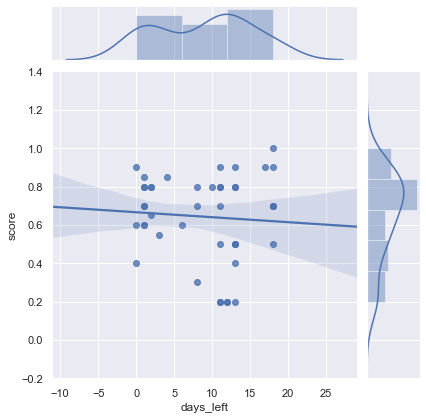

In [65]:
# Relationship between non-regular users' scores and days left
sns.jointplot(x='days_left',y='score',data=df_non_reg_users,kind='reg')

Across all modules, there seems to be no linear relationship between scores and the number of days left. The regression lines plotted are almost hortizontal for all modules.

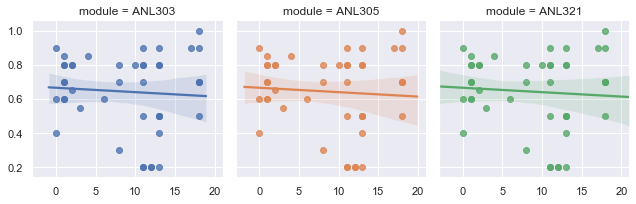

In [66]:
# Relationship between non-regular users' scores and days left according to module

g5 = sns.FacetGrid(df_non_reg_users,col='module',hue='module')
g5 = g5.map(sns.regplot, x='days_left',y='score',data=df_non_reg_users)

### 4. Linear Regression Model

The initial idea was to construct a linear regression model to predict the student's final official grade based on the data collected from the bot. This would involve students willingly reporting their grade for the 3 modules after receiving their final results. This was not implemented as users did not feel comfortable in divulging such information.

Hence, the model built here aims to predict the quiz score based on a select number of features. This section details the selection, preparation, construction and evaluation of the model.

####  a. Feature selection
Selection of attributes that should be inputted into the model

In [67]:
# Existing features in the dataset
df.columns

Index(['user_id', 'module', 'num_q', 'r_score', 'datetime', 'score', 'z_score',
       'exam_date', 'date', 'time', 'days_left'],
      dtype='object')

The table below displays the attributes that currently exist in the dataset. Supporting reasons are also provided for attributes that were not selected.

| Attribute | Data type | Included in model | Reason for exclusion |
| --- | --- | --- | --- |
| module  | nominal** | regressor |
| num_q   | discrete | regressor | 
| days_left | continuous | regressor |
| score | continuous | dependent variable |
||
| r_score | continuous | no | used to derive 'score' |
| datetime | datetime | no | used to derive 'days_left' |
| user_id | nominal | no | record identifier | 
| z-score| continuos | no | normalized 'score' |
| exam_date | datetime | no | used to derive 'days_left' |
| date | date | no | used to derive 'days_left' |
| time | time | no | used to derive 'days_left' |


                                               ** data preparation needed

#### b. Deriving new attributes

In section 3 (analysis) of this report, users were split into regular & non-regular. Thus, the type of user can be a new attribute to be included in the model.

In [68]:
# Add new attribute: type of user (non-reg = 0, reg =1)
df['type_of_user']=0

In [69]:
# Assign reg users = 1
df.loc[df['user_id'].isin(reg_users),['type_of_user']]=1

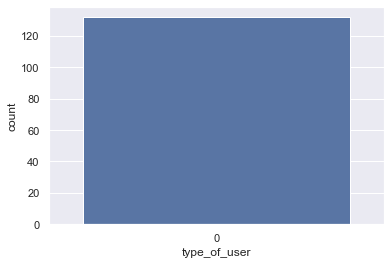

In [70]:
# Bar plot of user type
sns.countplot(df['type_of_user'])

#### c. Data preparation

The attribute 'module' is currently nominal. It needs to be encoded into numerical values in order for the linear regression model to make use of it. Here, the dummy encoding method was utilised, resulting in 2 <i>(k</i>-1) variables. ANL321 was chosen as the reference module. 

In [71]:
# Encode module name to numerical values
df['anl303']=df['module'].apply(lambda x: 1 if x =='ANL303' else 0 )

In [72]:
df['anl305']=df['module'].apply(lambda x: 1 if x =='ANL305' else 0 )

In [73]:
# Check that encoding was performed correctly
sum(df[['anl303','anl305']].sum(axis=1)>1)

0

#### d. Model construction
The dataset is first partitioned into training and testing sets with a ratio of 70:30. The training set represents the data that is input to construct the model. The testing set is later used in the next sub-section to evaluate the performance of the model on "unseen" data.

In [74]:
# Assign X and y to selected regressors and dependent variable respectively

X = df[['num_q' ,'days_left', 'anl303', 'anl305']]
y = df['score']

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [76]:
# Partition dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [77]:
# Feed training data into model
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<strong>Interpretation of coefficients:</strong>
<ol>
    <li>On average, a one unit increase in number of questions selected leads to a 0.0077 increase in
        score holding all other factors constant.</li>
    <li>On average, a one unit decrease in the number of days left leads to a 0.0129 increase in score,
        holding all other factors constant.</li>
    <li>On average, scores for anl303 are 0.0374 higher than anl321, holding all other factors constant.</li>
<li>On average, scores for anl305 are 0.1042 higher than anl321, holding all other factors constant</li></ol>

In [78]:
coeff_df = pd.DataFrame(lm.coef_, X.columns,columns=['Coefficient'])
print(f'intercept = {lm.intercept_}')
coeff_df

intercept = 0.6786137396223938


,Coefficient
num_q,0.004414
days_left,-0.010534
anl303,0.101955
anl305,0.098515


#### e. Evaluate predictions

This subsection aims to evaluate the performance of the model by comparing the predicted and actual scores of the testing set.

In [79]:
predictions = lm.predict(X_test)

In [80]:
# Convert predictions object type to pandas Series
predictions = pd.Series(predictions)
type(predictions)

pandas.core.series.Series

The correlation coefficient of between the predicted and actual scores was computed to be 0.2949. This suggests that the model is only able to explain 29.49% of the variance in scores. The scatterplot (x axis = predicted score, y axis = actual score) displays the model's weak fit to the data.

In [81]:
y_test.corr(predictions)

0.18531246495113787

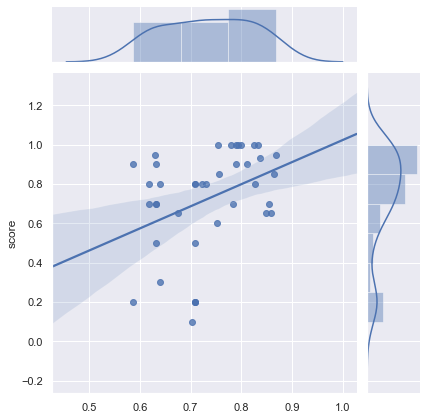

In [82]:
sns.jointplot(x=predictions,y=y_test,kind='reg')

In [83]:
# Reset y_test index
y_test.reset_index(drop=True,inplace=True)

In [84]:
# Distribution of residuals
residuals = pd.DataFrame(data={'predicted score':predictions, 'residual':y_test-predictions,})
residuals.head()

,predicted score,residual
0,0.826708,-0.026708
1,0.708829,-0.508829
2,0.629943,0.320057
3,0.585805,-0.385805
4,0.631649,0.268351


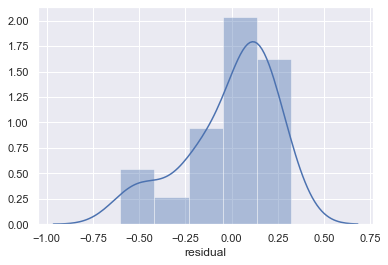

In [85]:
# Distribution of residuals
sns.distplot(residuals['residual'])

The figure belows shows a scatter plot of residuals against predicted scores. There is no recognisable pattern in the residuals.

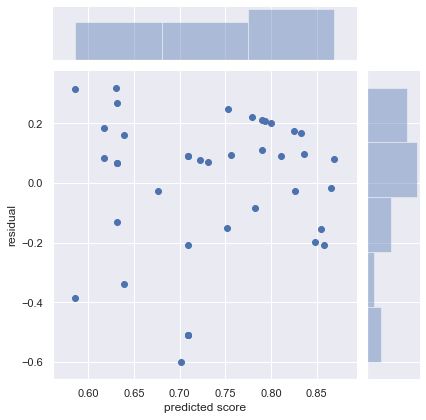

In [86]:
# Scatter plot of residuals and predicted values
sns.jointplot(x='predicted score',y='residual',data=residuals,kind='scatter')

In [87]:
# Import metrics module
from sklearn import metrics

In [88]:
# Calculate MSE
print(f'MSE: {metrics.mean_squared_error(y_test,predictions)}')

MSE: 0.057932039850931275


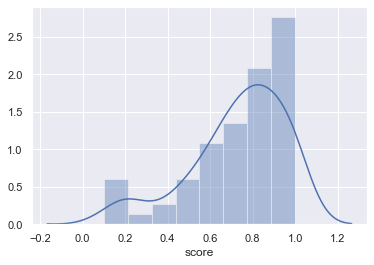

In [89]:
sns.distplot(df['score'])